<a href="https://colab.research.google.com/github/kashafali8/Deep_Reinforcement_Learning_A2/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation

*   Use Master Version of SB3

In [1]:
%%capture
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra] pyglet==1.5.27


*  Import DQN and Evaluation Helper



In [2]:
import gym
import numpy as np
import torch as th
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

Training "Vanilla DQN"

*   use default enable_double_dqn value = False

Step 1: Create the Environments (Training & Evaluation)

In [3]:
## Training environment of Cartpole
train_env = gym.make('MountainCar-v0')

## Evalutation environment of Cartpole
evaluation_env = gym.make('MountainCar-v0')

In [4]:
tensorboard_log = "data/tb/"

Step 2: Evaluate the Agent before Training

In [5]:
dqn_vanilla = DQN("MlpPolicy",
              train_env,
              verbose=1,
              train_freq=16,
              gradient_steps=8,
              gamma=0.99,
              exploration_fraction=0.2,
              exploration_final_eps=0.07,
              target_update_interval=600,
              learning_starts=1000,
              buffer_size=10000,
              batch_size=128,
              learning_rate=4e-3,
              policy_kwargs=dict(net_arch=[256, 256]),
              tensorboard_log=tensorboard_log,
              seed=2)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [6]:
mean_reward, std_reward = evaluate_policy(dqn_vanilla, evaluation_env, deterministic=True, n_eval_episodes=100)

print(f"Mean Reward for Vanilla DQN:{mean_reward:.2f} +/- {std_reward:.2f}")

/usr/local/lib/python3.8/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean Reward for Vanilla DQN:-200.00 +/- 0.00


Step 3: Train the agent until convergence and then analyse the learned q-value function.

In [9]:
dqn_vanilla.learn(int(1.2e5), log_interval=10)

Logging to data/tb/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.922    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 358      |
|    time_elapsed     | 5        |
|    total_timesteps  | 2000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 2.29e-05 |
|    n_updates        | 496      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.845    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 353      |
|    time_elapsed     | 11       |
|    total_timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 1.52e-

Step 4: Evaluate after training, the mean episodic reward should have improved.

In [10]:
mean_reward, std_reward = evaluate_policy(dqn_vanilla, evaluation_env, deterministic=True, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/usr/local/lib/python3.8/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:-187.99 +/- 32.63


Mean episodic reward has improved from -200 to -187.99

Step 5: Video Recording

In [11]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [12]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [13]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make(env_id)])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs, deterministic=False)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

Step 6: Visualize trained agent

In [14]:
record_video('MountainCar-v0', dqn_vanilla, video_length=500, prefix='dqn-mountaincar')

Saving video to /content/videos/dqn-mountaincar-step-0-to-step-500.mp4


In [15]:
show_videos('videos', prefix='dqn')

Step 7: Visualize Q-values

In [17]:
def get_q_values(model: DQN, obs: np.ndarray) -> np.ndarray:
    """
    Retrieve Q-values for a given observation.

    :param model: a DQN model
    :param obs: a single observation
    :return: the associated q-values for the given observation
    """
    assert model.get_env().observation_space.contains(obs), f"Invalid observation of shape {obs.shape}: {obs}"
    ### YOUR CODE HERE
    
    # Retrieve q-values for the given observation and convert them to numpy
    with th.no_grad():
      ## Create a tensor of the observation numpy array
      observation_tensor = th.from_numpy(obs).unsqueeze(0)

      ## Pass the observation through the Q network to fetch the Q Values
      q_values = dqn_vanilla.q_net(observation_tensor)
      
      ## Convert Q values tensor to numpy array
      q_values = q_values.squeeze().numpy()
    
    ### END OF YOUR CODE
    assert isinstance(q_values, np.ndarray), "The returned q_values is not a numpy array"
    assert q_values.shape == (3,), f"Wrong shape: (3,) was expected but got {q_values.shape}"

    return q_values

Q-values for the initial state:

* Let's reset the environment to start a new episode:
* we plot the rendered environment to visualize it

In [19]:
obs = train_env.reset()

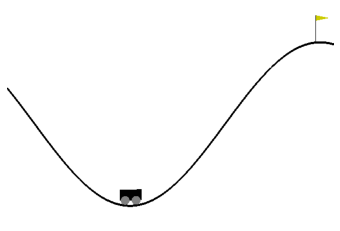

In [21]:
plt.axis('off')
plt.imshow(train_env.render(mode="rgb_array"))

Step 7: Exercise (5 minutes)- predict taken action according to q-values

Using the `get_q_values()` function, retrieve the q-values for the initial observation, print them for each action ("left", "nothing", "right") and print the action that the greedy (deterministic) policy would follow (i.e., the action with the highest q-value for that state).

In [22]:
action_str = ["Left", "Nothing", "Right"]  # action=0 -> go left, action=1 -> do nothing, action=2 -> go right

In [24]:
### YOUR CODE HERE
# Retrieve q-values for the initial state
# You should use `get_q_values()`

## Fetching the Q values using our function
q_values = get_q_values(dqn_vanilla, obs)

## Unwrapping the Q values
q_value_left, q_value_nothing, q_value_right = q_values

### END OF YOUR CODE

print(f"Q-value of the initial state left={q_value_left:.2f} nothing={q_value_nothing:.2f} right={q_value_right:.2f}")

### YOUR CODE HERE
# Compute the action taken in the initilal state according to q-values 
# when following a greedy strategy

action = np.argmax(q_values)

## END of your code here

print(f"Action taken by the greedy policy in the initial state: {action_str[action]}")

Q-value of the initial state left=-64.73 nothing=-64.25 right=-64.72
Action taken by the greedy policy in the initial state: Nothing


The q-value of the initial state corresponds to how much (discounted) reward the agent expects to get in this episode.

We will compare the estimated q-value to the discounted return of the episode.

In [25]:
initial_q_value = q_values.max()

Step 8: Step until the end of the episode


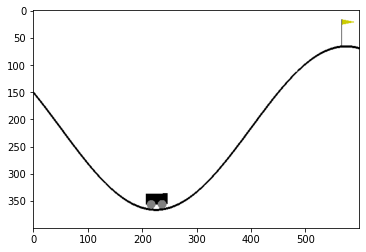

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.72
Action: Nothing


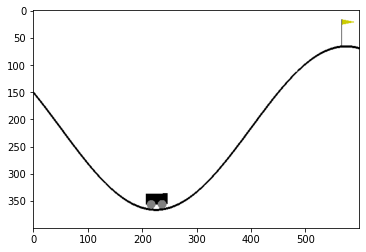

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.73
Action: Nothing


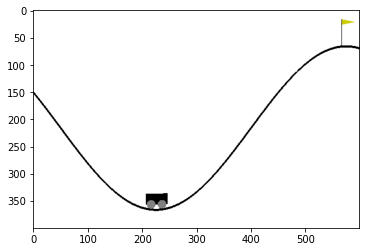

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.73
Action: Nothing


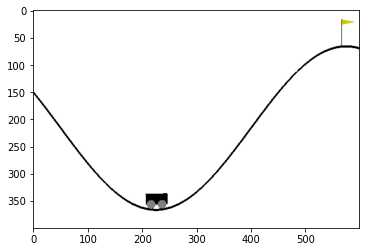

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.73
Action: Nothing


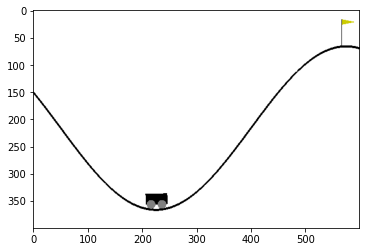

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.73
Action: Nothing


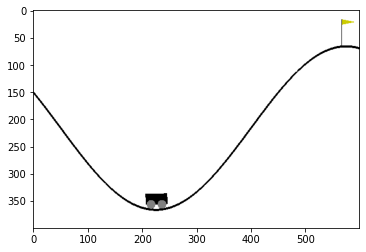

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.74
Action: Nothing


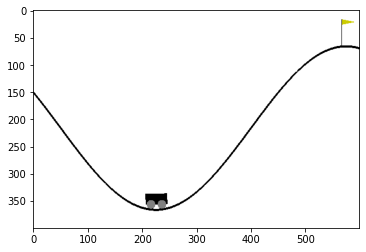

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.74
Action: Nothing


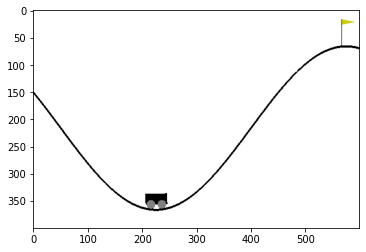

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.74
Action: Nothing


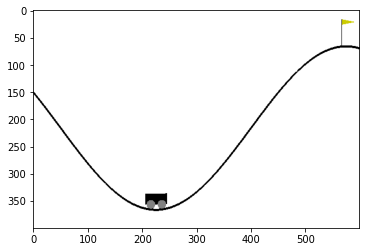

Q-value of the current state left=-64.72 nothing=-64.25 right=-64.74
Action: Nothing


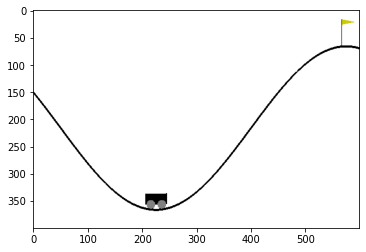

Q-value of the current state left=-64.72 nothing=-64.25 right=-64.74
Action: Nothing


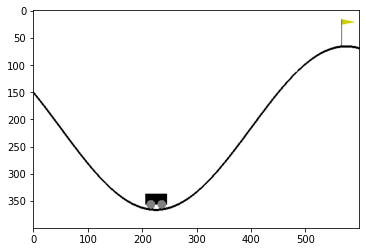

Q-value of the current state left=-64.72 nothing=-64.25 right=-64.74
Action: Nothing


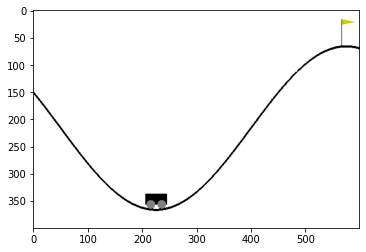

Q-value of the current state left=-64.72 nothing=-64.25 right=-64.74
Action: Nothing


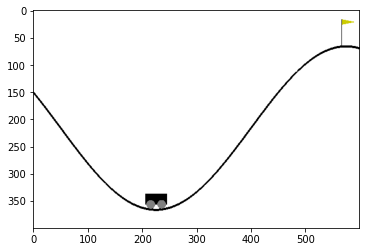

Q-value of the current state left=-64.71 nothing=-64.25 right=-64.74
Action: Nothing


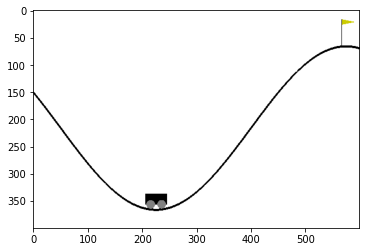

Q-value of the current state left=-64.71 nothing=-64.25 right=-64.74
Action: Nothing


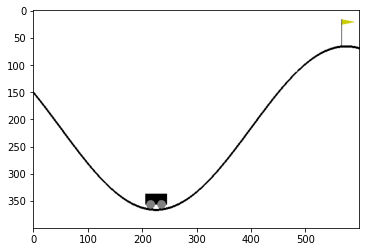

Q-value of the current state left=-64.71 nothing=-64.24 right=-64.74
Action: Nothing


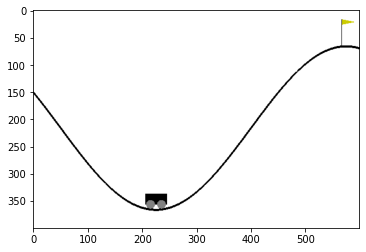

Q-value of the current state left=-64.70 nothing=-64.24 right=-64.74
Action: Nothing


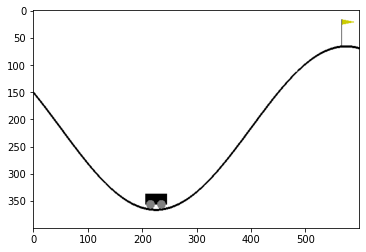

Q-value of the current state left=-64.70 nothing=-64.24 right=-64.74
Action: Nothing


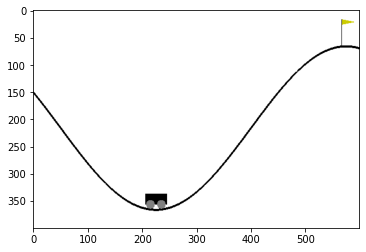

Q-value of the current state left=-64.70 nothing=-64.24 right=-64.74
Action: Nothing


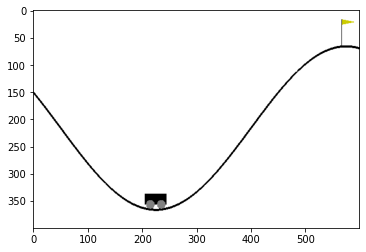

Q-value of the current state left=-64.69 nothing=-64.23 right=-64.73
Action: Nothing


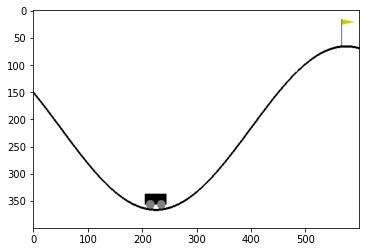

Q-value of the current state left=-64.69 nothing=-64.23 right=-64.73
Action: Nothing


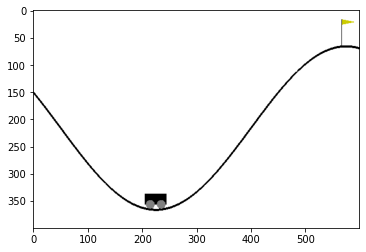

Q-value of the current state left=-64.68 nothing=-64.23 right=-64.73
Action: Nothing


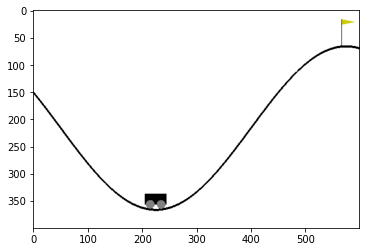

Q-value of the current state left=-64.68 nothing=-64.22 right=-64.73
Action: Nothing


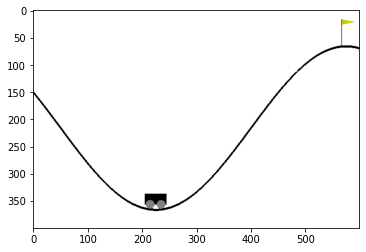

Q-value of the current state left=-64.68 nothing=-64.22 right=-64.72
Action: Nothing


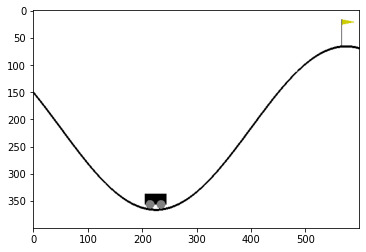

Q-value of the current state left=-64.67 nothing=-64.22 right=-64.72
Action: Nothing


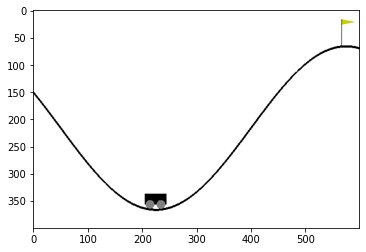

Q-value of the current state left=-64.67 nothing=-64.21 right=-64.72
Action: Nothing


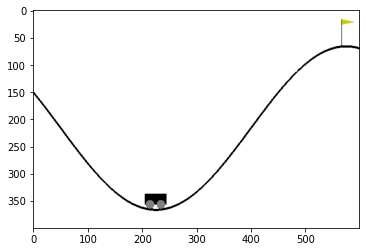

Q-value of the current state left=-64.67 nothing=-64.21 right=-64.71
Action: Nothing


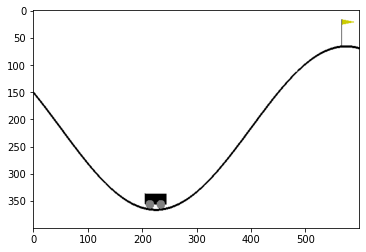

Q-value of the current state left=-64.66 nothing=-64.21 right=-64.71
Action: Nothing


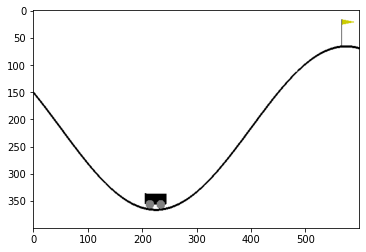

Q-value of the current state left=-64.66 nothing=-64.20 right=-64.70
Action: Nothing


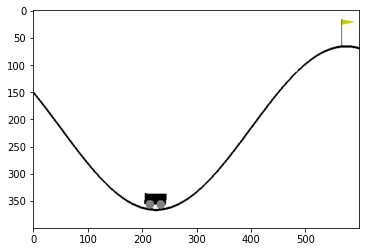

Q-value of the current state left=-64.66 nothing=-64.20 right=-64.70
Action: Nothing


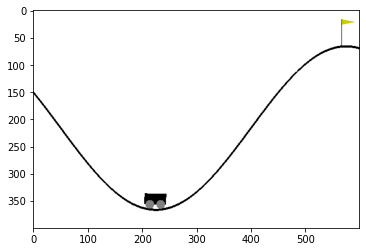

Q-value of the current state left=-64.65 nothing=-64.20 right=-64.70
Action: Nothing


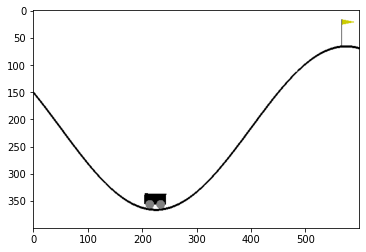

Q-value of the current state left=-64.65 nothing=-64.19 right=-64.69
Action: Nothing


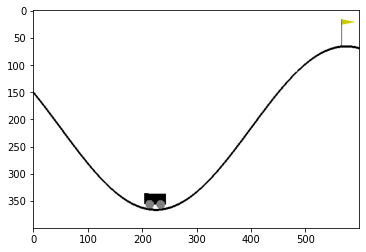

Q-value of the current state left=-64.65 nothing=-64.19 right=-64.69
Action: Nothing


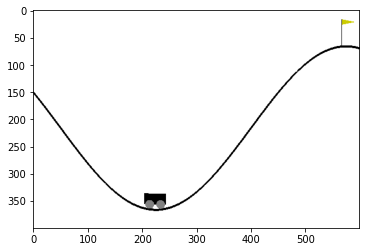

Q-value of the current state left=-64.65 nothing=-64.19 right=-64.68
Action: Nothing


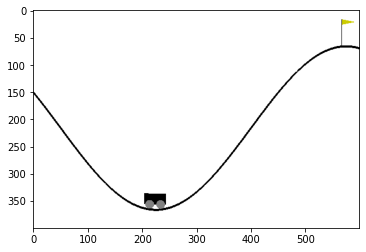

Q-value of the current state left=-64.64 nothing=-64.18 right=-64.68
Action: Nothing


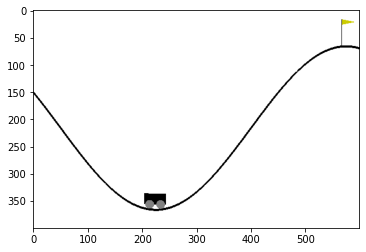

Q-value of the current state left=-64.64 nothing=-64.18 right=-64.68
Action: Nothing


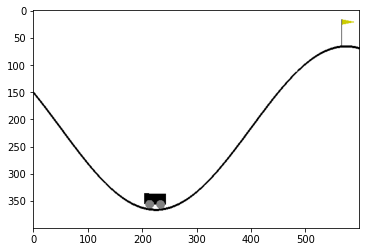

Q-value of the current state left=-64.64 nothing=-64.18 right=-64.67
Action: Nothing


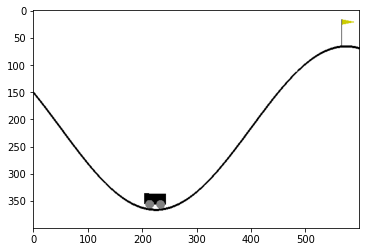

Q-value of the current state left=-64.64 nothing=-64.18 right=-64.67
Action: Nothing


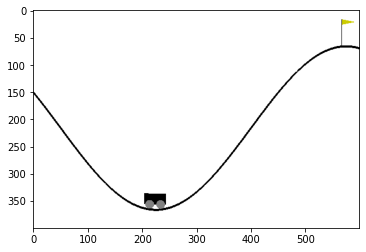

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.67
Action: Nothing


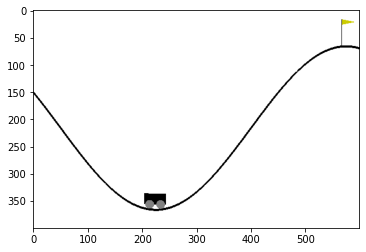

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.66
Action: Nothing


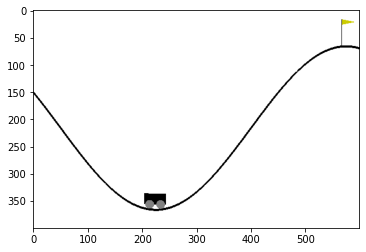

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.66
Action: Nothing


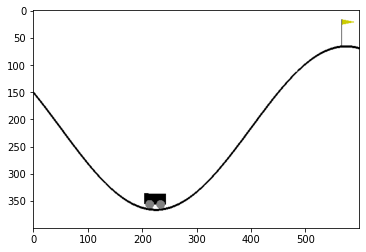

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.66
Action: Nothing


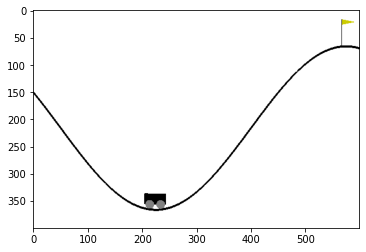

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.66
Action: Nothing


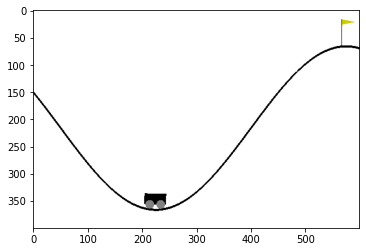

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.65
Action: Nothing


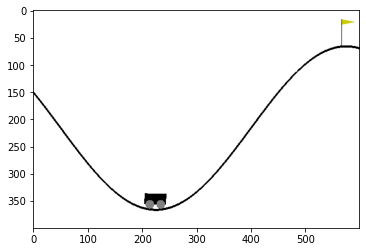

Q-value of the current state left=-64.65 nothing=-64.17 right=-64.65
Action: Nothing


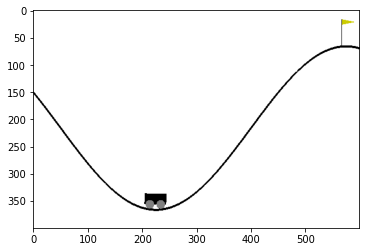

Q-value of the current state left=-64.65 nothing=-64.17 right=-64.65
Action: Nothing


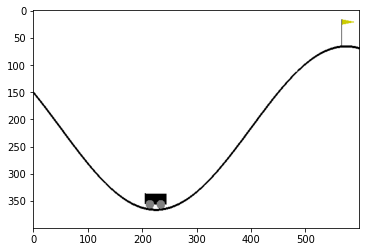

Q-value of the current state left=-64.65 nothing=-64.17 right=-64.65
Action: Nothing


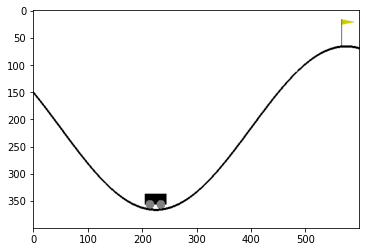

Q-value of the current state left=-64.65 nothing=-64.17 right=-64.65
Action: Nothing


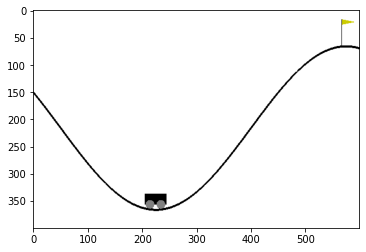

Q-value of the current state left=-64.65 nothing=-64.17 right=-64.65
Action: Nothing


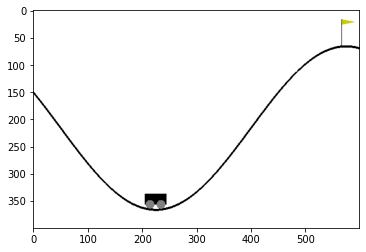

Q-value of the current state left=-64.66 nothing=-64.18 right=-64.65
Action: Nothing


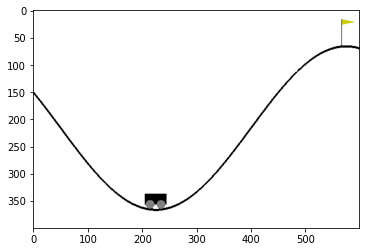

Q-value of the current state left=-64.66 nothing=-64.18 right=-64.65
Action: Nothing


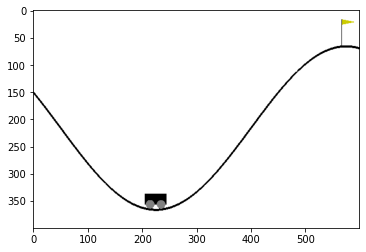

Q-value of the current state left=-64.66 nothing=-64.18 right=-64.65
Action: Nothing


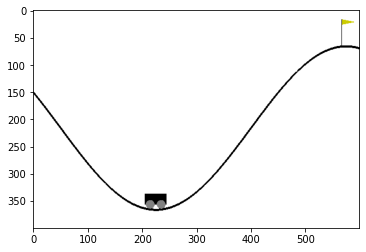

Q-value of the current state left=-64.67 nothing=-64.18 right=-64.65
Action: Nothing


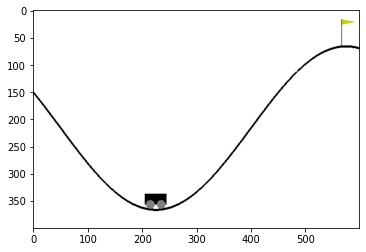

Q-value of the current state left=-64.67 nothing=-64.18 right=-64.65
Action: Nothing


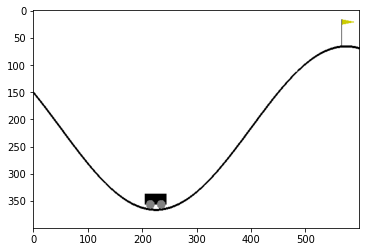

Q-value of the current state left=-64.68 nothing=-64.19 right=-64.65
Action: Nothing


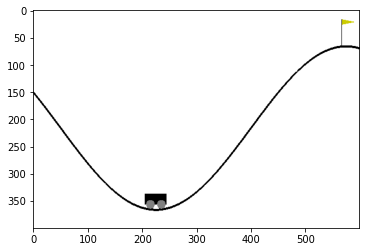

Q-value of the current state left=-64.68 nothing=-64.19 right=-64.66
Action: Nothing


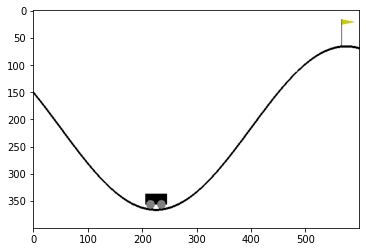

Q-value of the current state left=-64.68 nothing=-64.19 right=-64.66
Action: Nothing


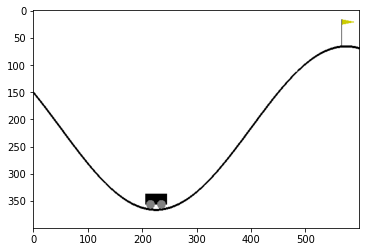

Q-value of the current state left=-64.69 nothing=-64.20 right=-64.66
Action: Nothing


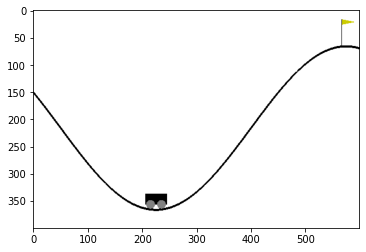

Q-value of the current state left=-64.69 nothing=-64.20 right=-64.66
Action: Nothing


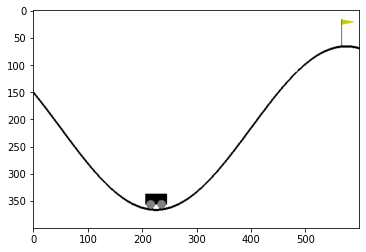

Q-value of the current state left=-64.69 nothing=-64.20 right=-64.67
Action: Nothing


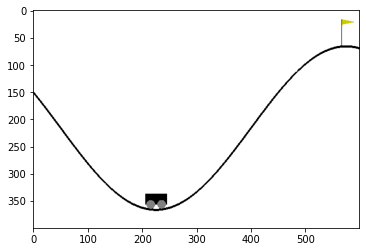

Q-value of the current state left=-64.70 nothing=-64.21 right=-64.67
Action: Nothing


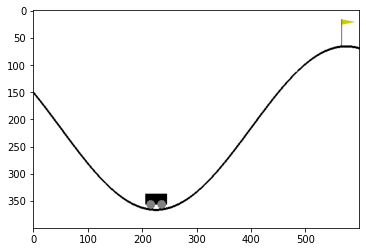

Q-value of the current state left=-64.70 nothing=-64.21 right=-64.67
Action: Nothing


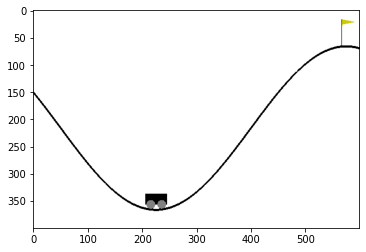

Q-value of the current state left=-64.71 nothing=-64.21 right=-64.68
Action: Nothing


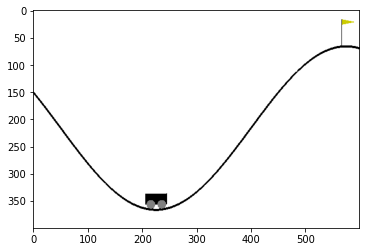

Q-value of the current state left=-64.71 nothing=-64.22 right=-64.68
Action: Nothing


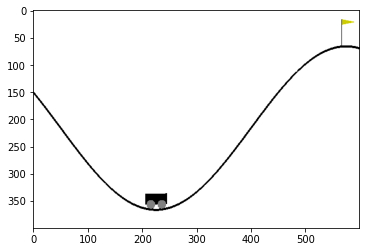

Q-value of the current state left=-64.71 nothing=-64.22 right=-64.69
Action: Nothing


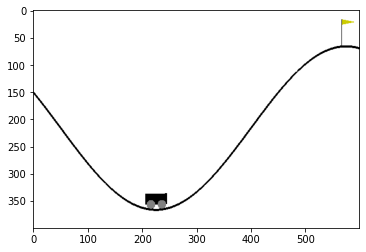

Q-value of the current state left=-64.72 nothing=-64.23 right=-64.69
Action: Nothing


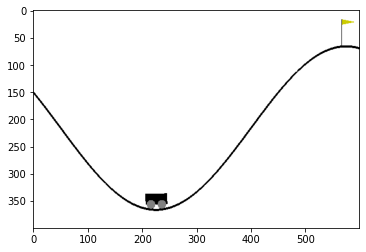

Q-value of the current state left=-64.72 nothing=-64.23 right=-64.69
Action: Nothing


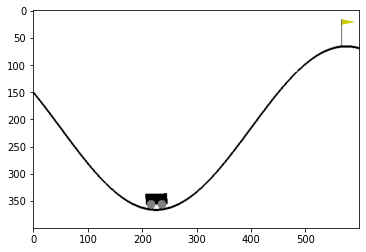

Q-value of the current state left=-64.72 nothing=-64.23 right=-64.70
Action: Nothing


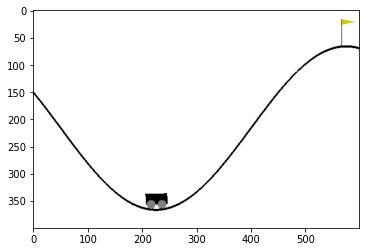

Q-value of the current state left=-64.72 nothing=-64.23 right=-64.70
Action: Nothing


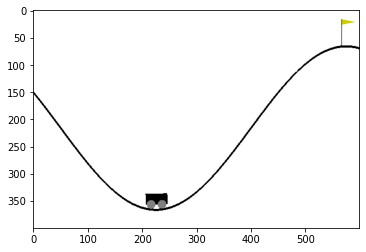

Q-value of the current state left=-64.73 nothing=-64.24 right=-64.71
Action: Nothing


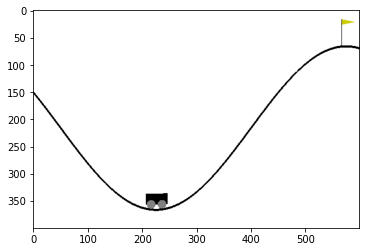

Q-value of the current state left=-64.73 nothing=-64.24 right=-64.71
Action: Nothing


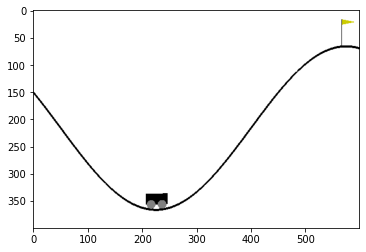

Q-value of the current state left=-64.73 nothing=-64.24 right=-64.71
Action: Nothing


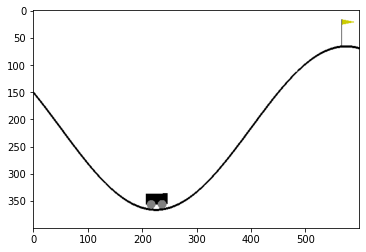

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.72
Action: Nothing


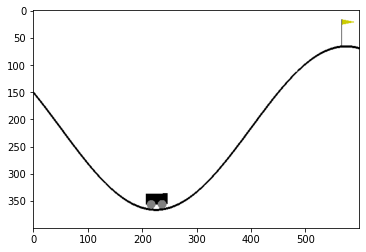

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.72
Action: Nothing


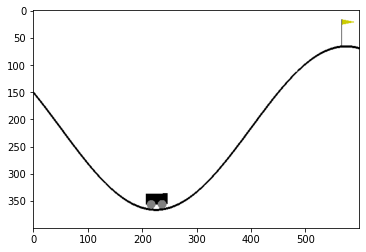

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.72
Action: Nothing


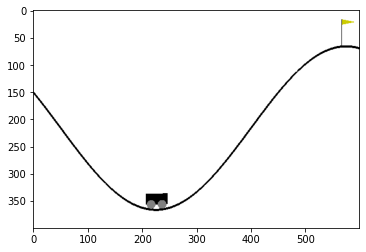

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.73
Action: Nothing


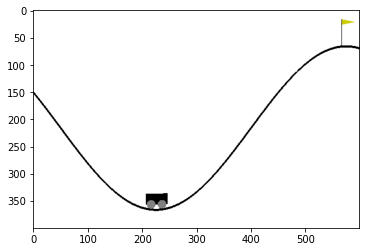

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.73
Action: Nothing


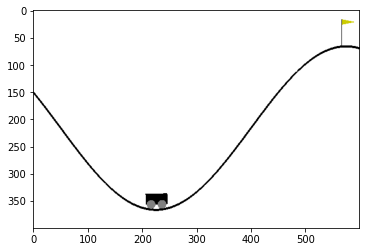

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.73
Action: Nothing


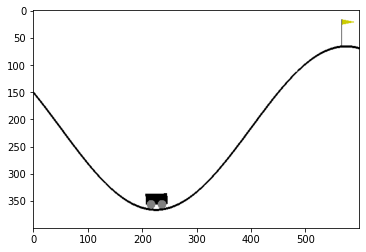

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.73
Action: Nothing


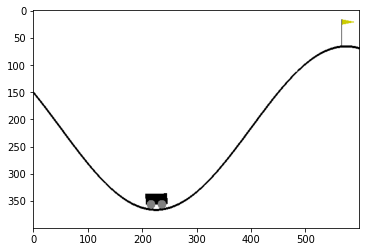

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.74
Action: Nothing


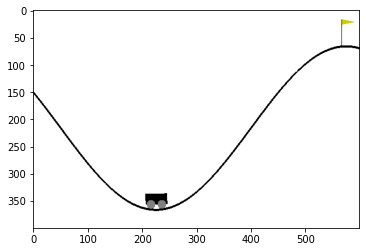

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.74
Action: Nothing


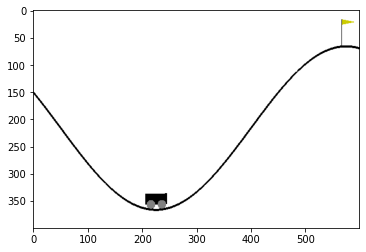

Q-value of the current state left=-64.72 nothing=-64.25 right=-64.74
Action: Nothing


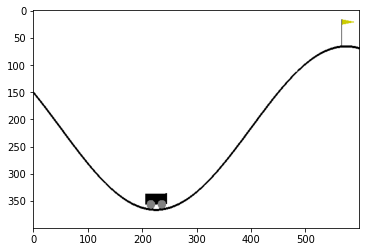

Q-value of the current state left=-64.72 nothing=-64.25 right=-64.74
Action: Nothing


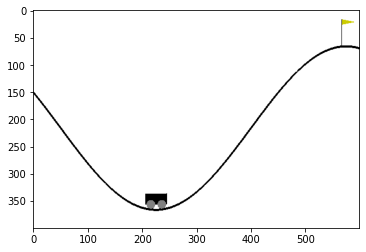

Q-value of the current state left=-64.72 nothing=-64.25 right=-64.74
Action: Nothing


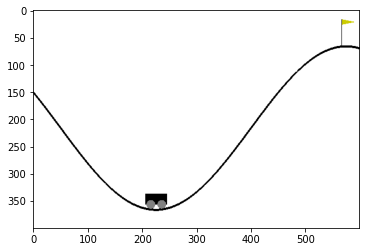

Q-value of the current state left=-64.72 nothing=-64.25 right=-64.74
Action: Nothing


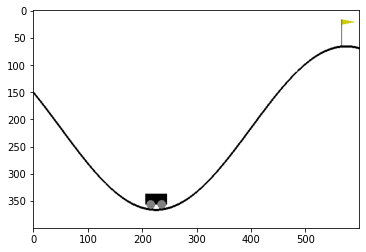

Q-value of the current state left=-64.72 nothing=-64.25 right=-64.74
Action: Nothing


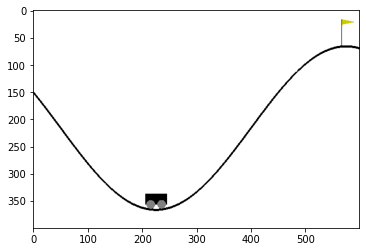

Q-value of the current state left=-64.71 nothing=-64.25 right=-64.74
Action: Nothing


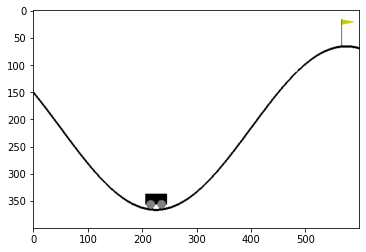

Q-value of the current state left=-64.71 nothing=-64.25 right=-64.74
Action: Nothing


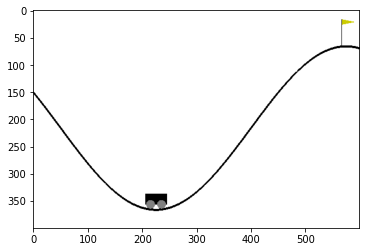

Q-value of the current state left=-64.71 nothing=-64.24 right=-64.74
Action: Nothing


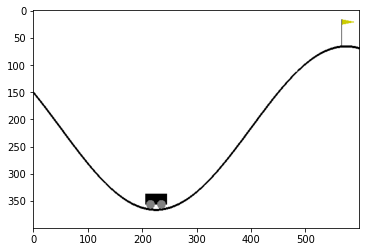

Q-value of the current state left=-64.70 nothing=-64.24 right=-64.74
Action: Nothing


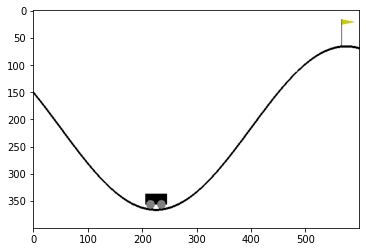

Q-value of the current state left=-64.70 nothing=-64.24 right=-64.74
Action: Nothing


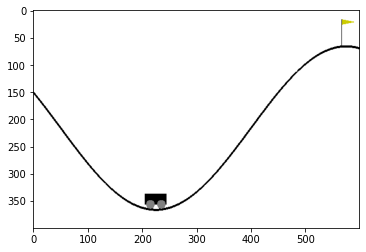

Q-value of the current state left=-64.69 nothing=-64.24 right=-64.73
Action: Nothing


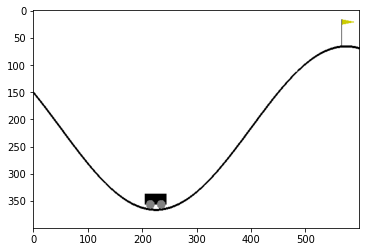

Q-value of the current state left=-64.69 nothing=-64.23 right=-64.73
Action: Nothing


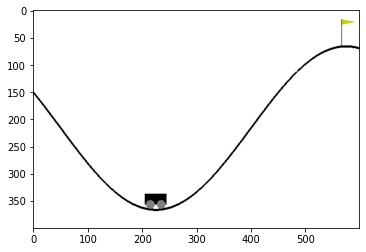

Q-value of the current state left=-64.69 nothing=-64.23 right=-64.73
Action: Nothing


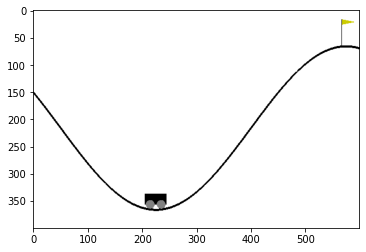

Q-value of the current state left=-64.68 nothing=-64.23 right=-64.73
Action: Nothing


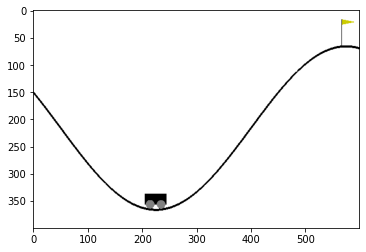

Q-value of the current state left=-64.68 nothing=-64.22 right=-64.72
Action: Nothing


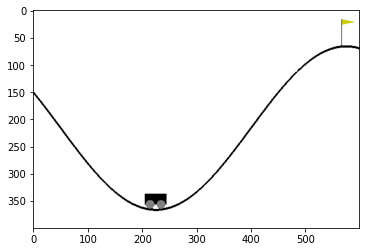

Q-value of the current state left=-64.67 nothing=-64.22 right=-64.72
Action: Nothing


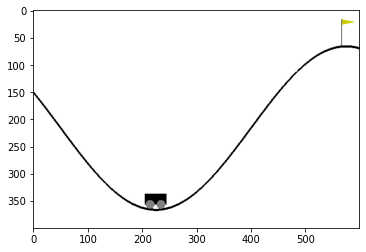

Q-value of the current state left=-64.67 nothing=-64.21 right=-64.72
Action: Nothing


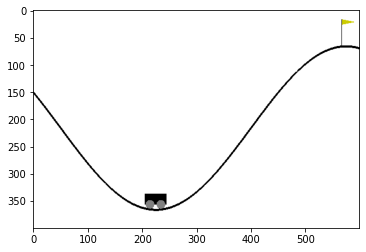

Q-value of the current state left=-64.67 nothing=-64.21 right=-64.71
Action: Nothing


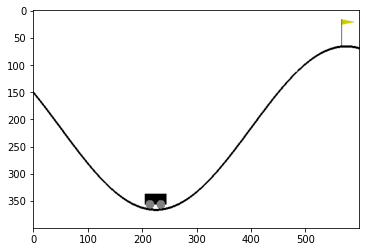

Q-value of the current state left=-64.66 nothing=-64.21 right=-64.71
Action: Nothing


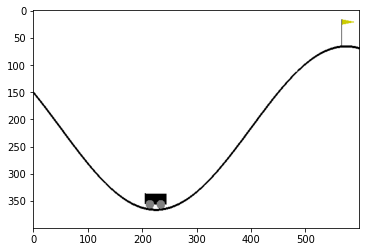

Q-value of the current state left=-64.66 nothing=-64.20 right=-64.71
Action: Nothing


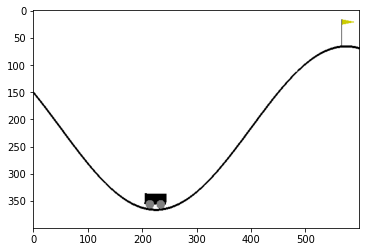

Q-value of the current state left=-64.66 nothing=-64.20 right=-64.70
Action: Nothing


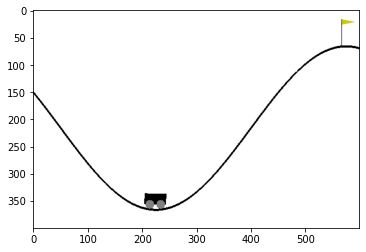

Q-value of the current state left=-64.65 nothing=-64.20 right=-64.70
Action: Nothing


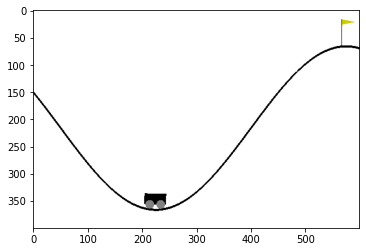

Q-value of the current state left=-64.65 nothing=-64.19 right=-64.69
Action: Nothing


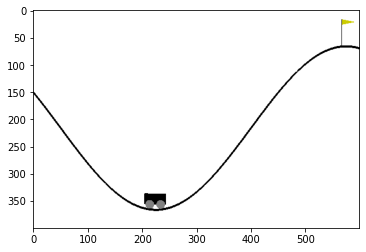

Q-value of the current state left=-64.65 nothing=-64.19 right=-64.69
Action: Nothing


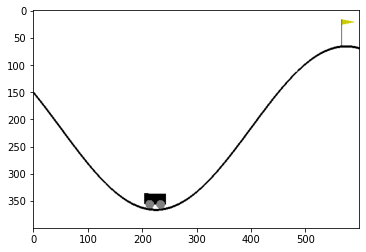

Q-value of the current state left=-64.65 nothing=-64.19 right=-64.69
Action: Nothing


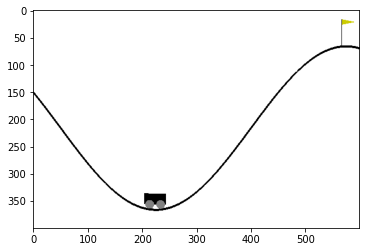

Q-value of the current state left=-64.65 nothing=-64.18 right=-64.68
Action: Nothing


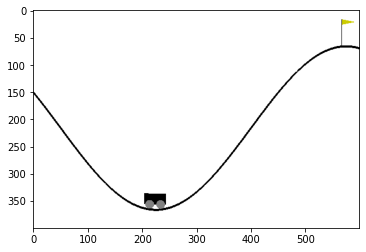

Q-value of the current state left=-64.64 nothing=-64.18 right=-64.68
Action: Nothing


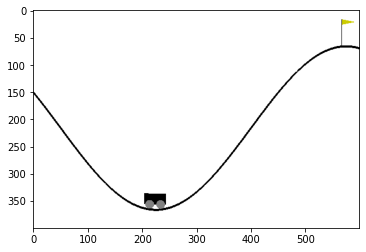

Q-value of the current state left=-64.64 nothing=-64.18 right=-64.67
Action: Nothing


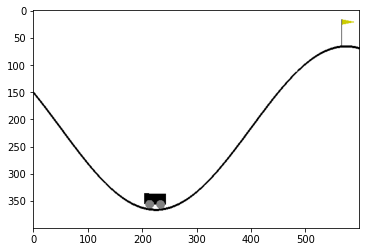

Q-value of the current state left=-64.64 nothing=-64.18 right=-64.67
Action: Nothing


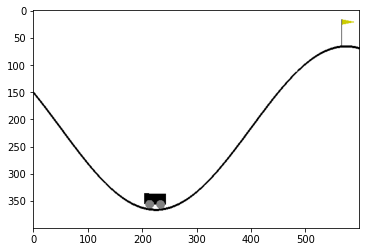

Q-value of the current state left=-64.64 nothing=-64.18 right=-64.67
Action: Nothing


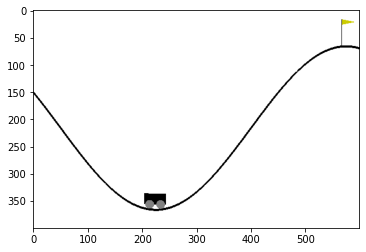

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.66
Action: Nothing


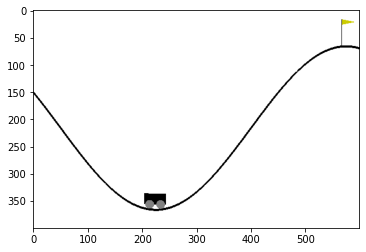

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.66
Action: Nothing


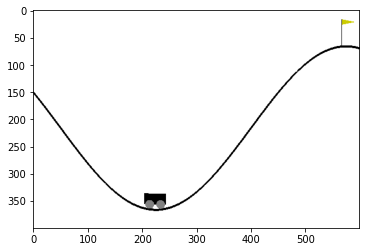

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.66
Action: Nothing


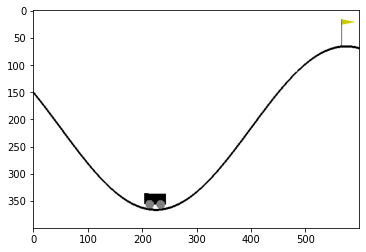

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.66
Action: Nothing


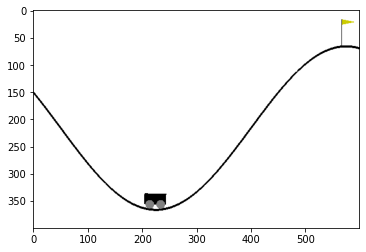

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.65
Action: Nothing


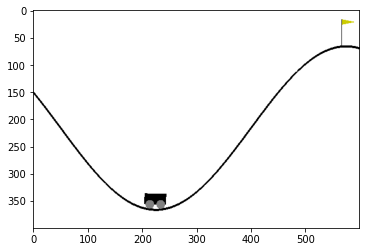

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.65
Action: Nothing


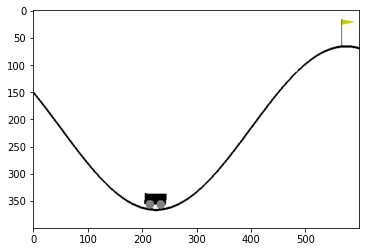

Q-value of the current state left=-64.65 nothing=-64.17 right=-64.65
Action: Nothing


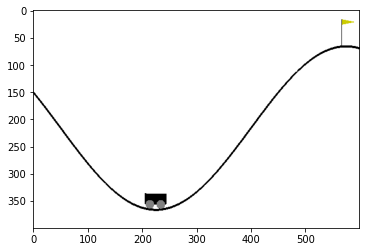

Q-value of the current state left=-64.65 nothing=-64.17 right=-64.65
Action: Nothing


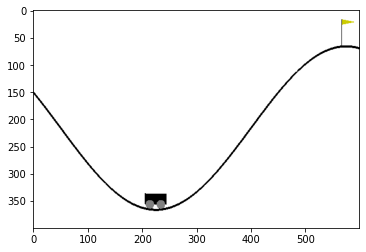

Q-value of the current state left=-64.65 nothing=-64.17 right=-64.65
Action: Nothing


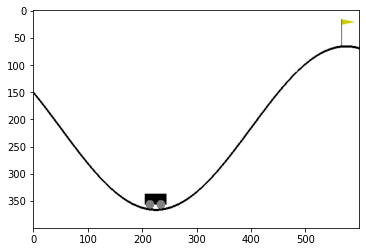

Q-value of the current state left=-64.65 nothing=-64.17 right=-64.65
Action: Nothing


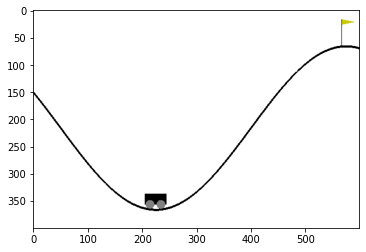

Q-value of the current state left=-64.66 nothing=-64.17 right=-64.65
Action: Nothing


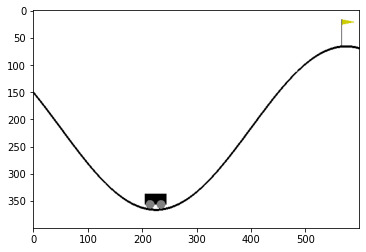

Q-value of the current state left=-64.66 nothing=-64.18 right=-64.65
Action: Nothing


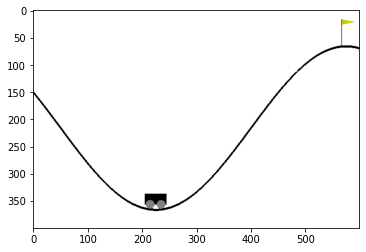

Q-value of the current state left=-64.66 nothing=-64.18 right=-64.65
Action: Nothing


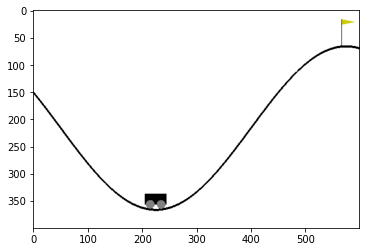

Q-value of the current state left=-64.67 nothing=-64.18 right=-64.65
Action: Nothing


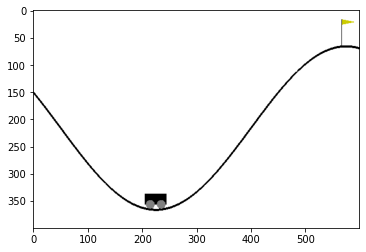

Q-value of the current state left=-64.67 nothing=-64.18 right=-64.65
Action: Nothing


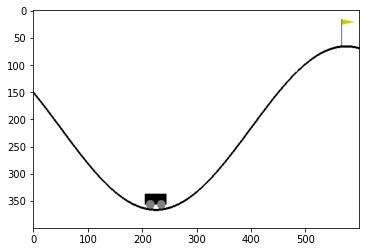

Q-value of the current state left=-64.67 nothing=-64.19 right=-64.65
Action: Nothing


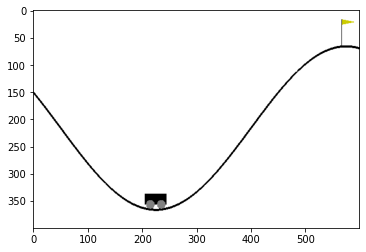

Q-value of the current state left=-64.68 nothing=-64.19 right=-64.66
Action: Nothing


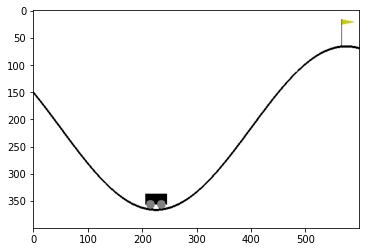

Q-value of the current state left=-64.68 nothing=-64.19 right=-64.66
Action: Nothing


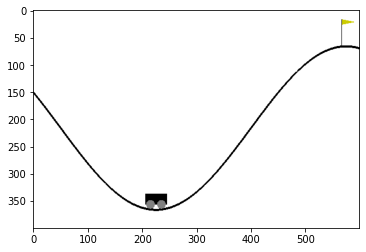

Q-value of the current state left=-64.68 nothing=-64.20 right=-64.66
Action: Nothing


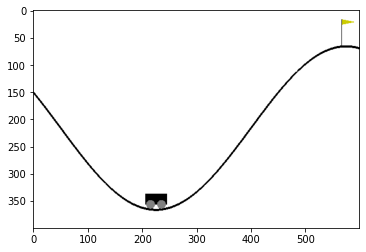

Q-value of the current state left=-64.69 nothing=-64.20 right=-64.66
Action: Nothing


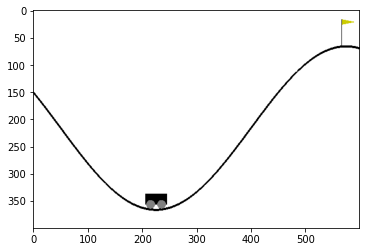

Q-value of the current state left=-64.69 nothing=-64.20 right=-64.67
Action: Nothing


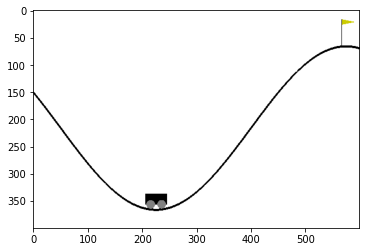

Q-value of the current state left=-64.70 nothing=-64.21 right=-64.67
Action: Nothing


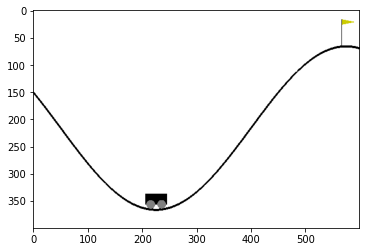

Q-value of the current state left=-64.70 nothing=-64.21 right=-64.67
Action: Nothing


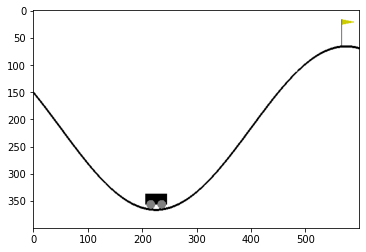

Q-value of the current state left=-64.70 nothing=-64.21 right=-64.68
Action: Nothing


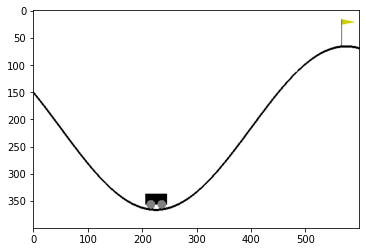

Q-value of the current state left=-64.71 nothing=-64.22 right=-64.68
Action: Nothing


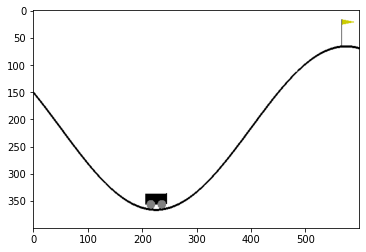

Q-value of the current state left=-64.71 nothing=-64.22 right=-64.68
Action: Nothing


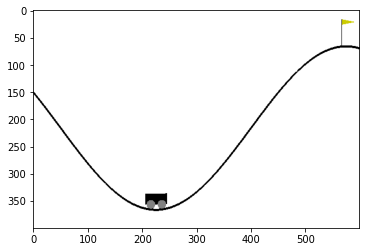

Q-value of the current state left=-64.71 nothing=-64.22 right=-64.69
Action: Nothing


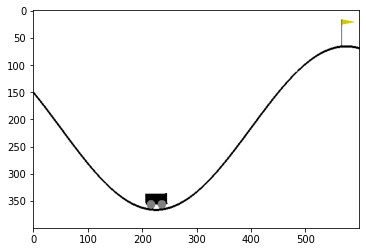

Q-value of the current state left=-64.72 nothing=-64.23 right=-64.69
Action: Nothing


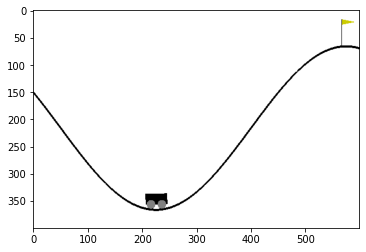

Q-value of the current state left=-64.72 nothing=-64.23 right=-64.70
Action: Nothing


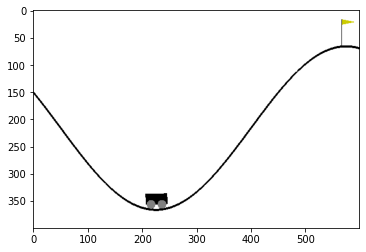

Q-value of the current state left=-64.72 nothing=-64.23 right=-64.70
Action: Nothing


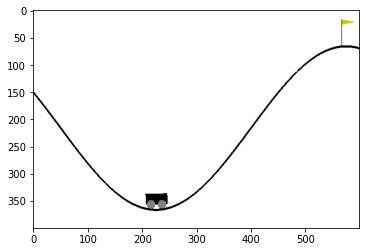

Q-value of the current state left=-64.72 nothing=-64.24 right=-64.70
Action: Nothing


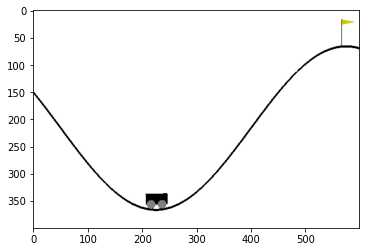

Q-value of the current state left=-64.73 nothing=-64.24 right=-64.71
Action: Nothing


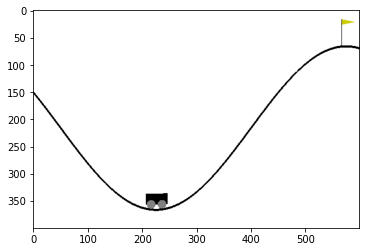

Q-value of the current state left=-64.73 nothing=-64.24 right=-64.71
Action: Nothing


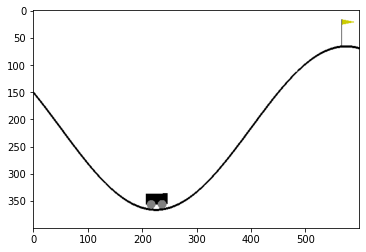

Q-value of the current state left=-64.73 nothing=-64.24 right=-64.71
Action: Nothing


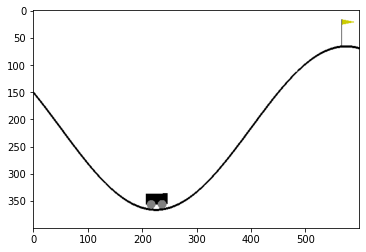

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.72
Action: Nothing


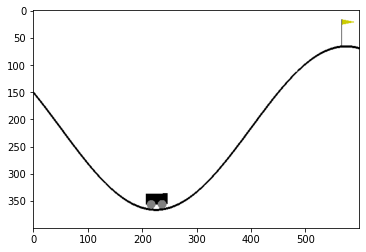

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.72
Action: Nothing


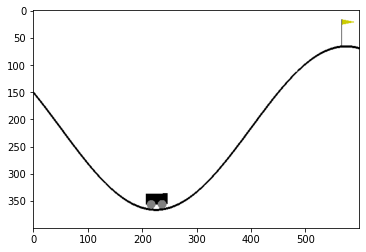

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.72
Action: Nothing


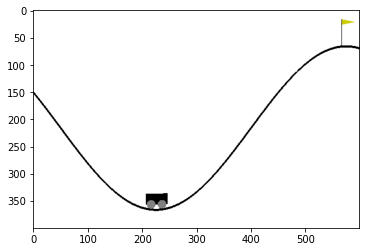

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.73
Action: Nothing


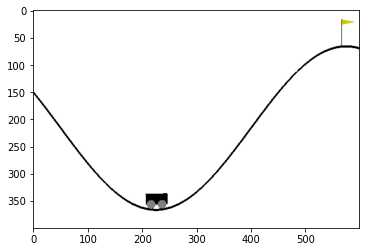

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.73
Action: Nothing


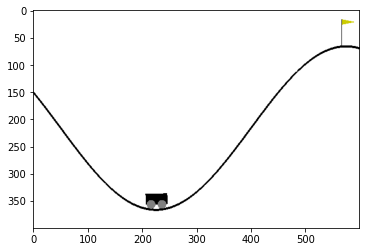

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.73
Action: Nothing


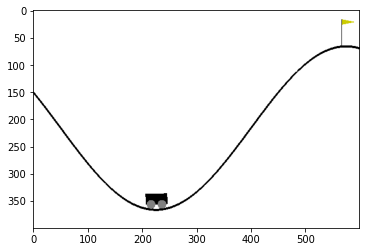

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.74
Action: Nothing


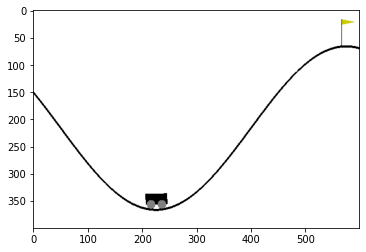

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.74
Action: Nothing


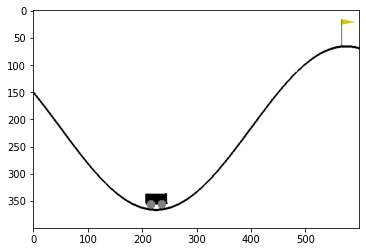

Q-value of the current state left=-64.73 nothing=-64.25 right=-64.74
Action: Nothing


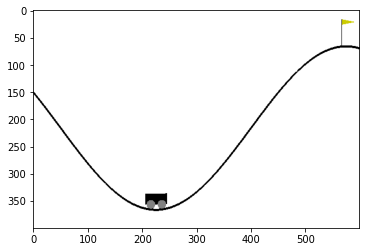

Q-value of the current state left=-64.72 nothing=-64.25 right=-64.74
Action: Nothing


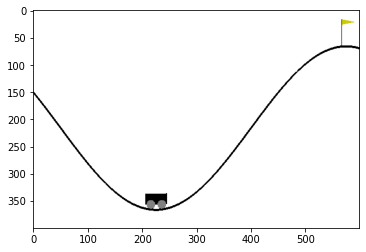

Q-value of the current state left=-64.72 nothing=-64.25 right=-64.74
Action: Nothing


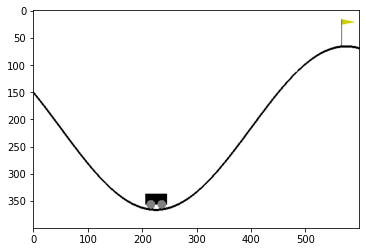

Q-value of the current state left=-64.72 nothing=-64.25 right=-64.74
Action: Nothing


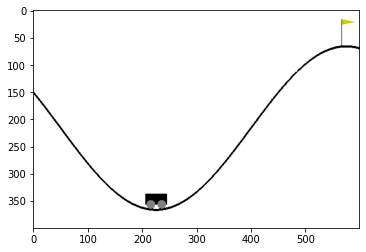

Q-value of the current state left=-64.72 nothing=-64.25 right=-64.74
Action: Nothing


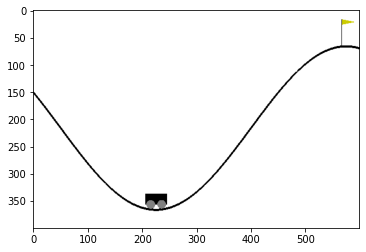

Q-value of the current state left=-64.71 nothing=-64.25 right=-64.74
Action: Nothing


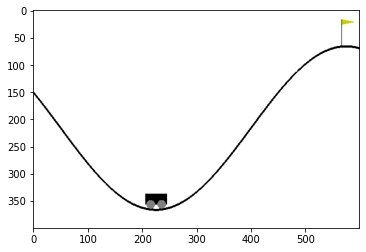

Q-value of the current state left=-64.71 nothing=-64.25 right=-64.74
Action: Nothing


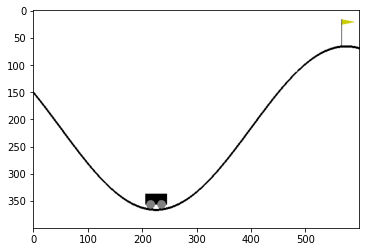

Q-value of the current state left=-64.71 nothing=-64.24 right=-64.74
Action: Nothing


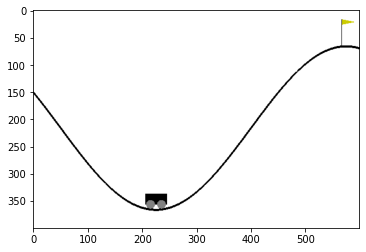

Q-value of the current state left=-64.70 nothing=-64.24 right=-64.74
Action: Nothing


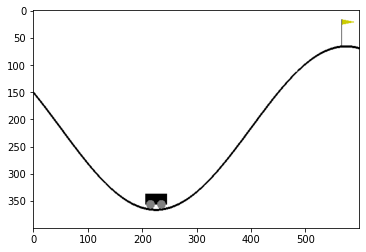

Q-value of the current state left=-64.70 nothing=-64.24 right=-64.74
Action: Nothing


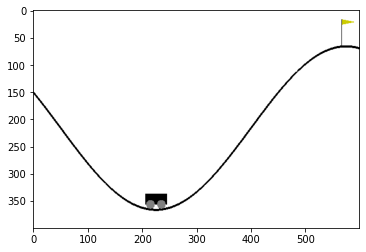

Q-value of the current state left=-64.70 nothing=-64.24 right=-64.74
Action: Nothing


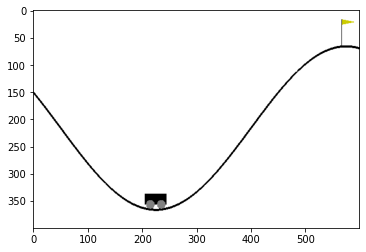

Q-value of the current state left=-64.69 nothing=-64.23 right=-64.73
Action: Nothing


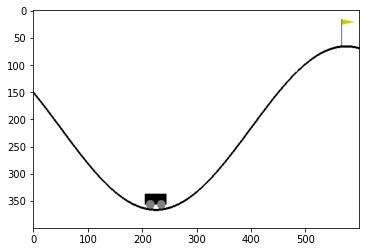

Q-value of the current state left=-64.69 nothing=-64.23 right=-64.73
Action: Nothing


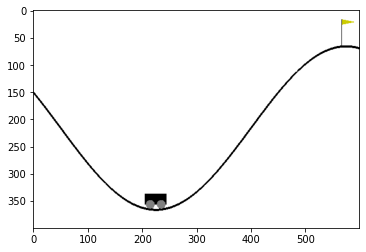

Q-value of the current state left=-64.68 nothing=-64.23 right=-64.73
Action: Nothing


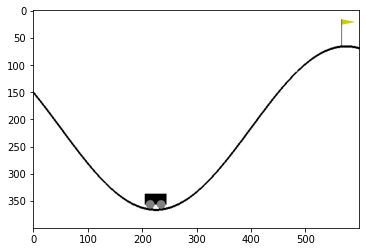

Q-value of the current state left=-64.68 nothing=-64.22 right=-64.73
Action: Nothing


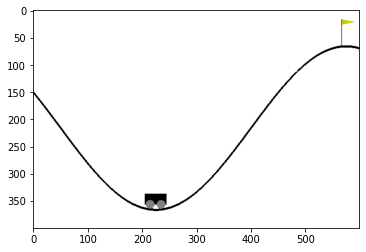

Q-value of the current state left=-64.68 nothing=-64.22 right=-64.72
Action: Nothing


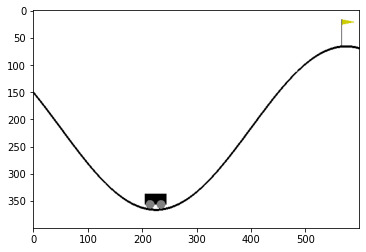

Q-value of the current state left=-64.67 nothing=-64.22 right=-64.72
Action: Nothing


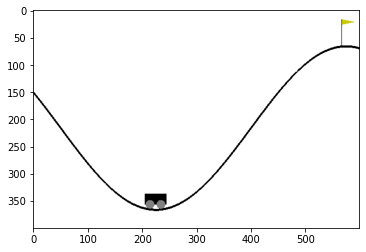

Q-value of the current state left=-64.67 nothing=-64.21 right=-64.72
Action: Nothing


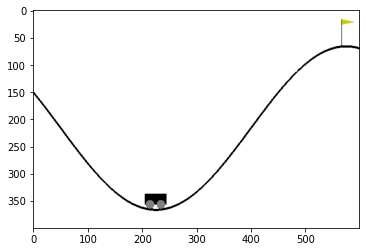

Q-value of the current state left=-64.67 nothing=-64.21 right=-64.71
Action: Nothing


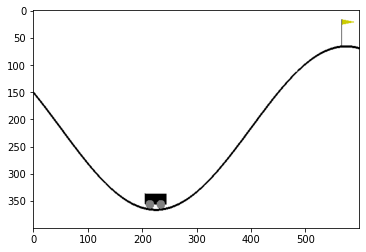

Q-value of the current state left=-64.66 nothing=-64.21 right=-64.71
Action: Nothing


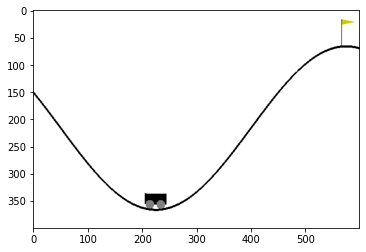

Q-value of the current state left=-64.66 nothing=-64.20 right=-64.70
Action: Nothing


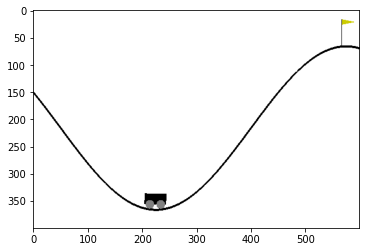

Q-value of the current state left=-64.66 nothing=-64.20 right=-64.70
Action: Nothing


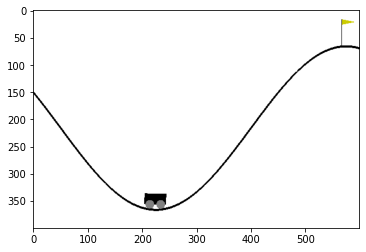

Q-value of the current state left=-64.65 nothing=-64.20 right=-64.70
Action: Nothing


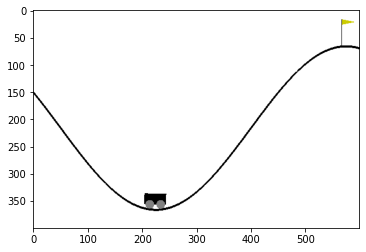

Q-value of the current state left=-64.65 nothing=-64.19 right=-64.69
Action: Nothing


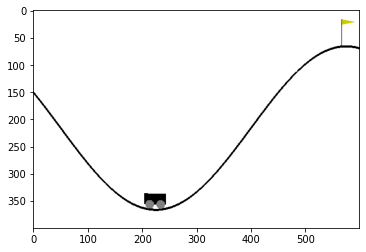

Q-value of the current state left=-64.65 nothing=-64.19 right=-64.69
Action: Nothing


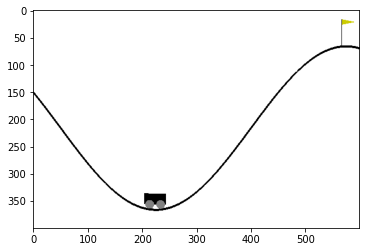

Q-value of the current state left=-64.65 nothing=-64.19 right=-64.68
Action: Nothing


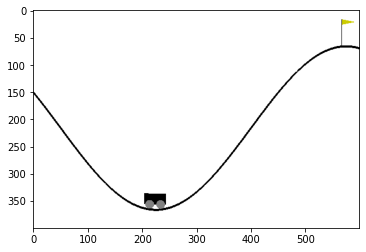

Q-value of the current state left=-64.64 nothing=-64.18 right=-64.68
Action: Nothing


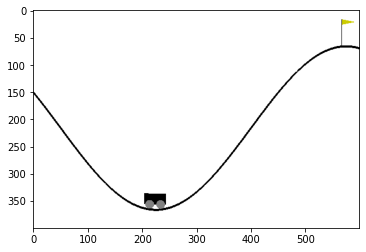

Q-value of the current state left=-64.64 nothing=-64.18 right=-64.68
Action: Nothing


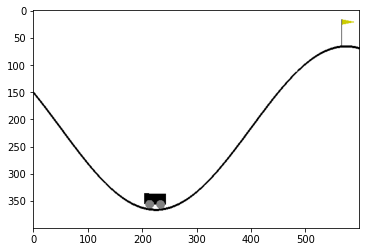

Q-value of the current state left=-64.64 nothing=-64.18 right=-64.67
Action: Nothing


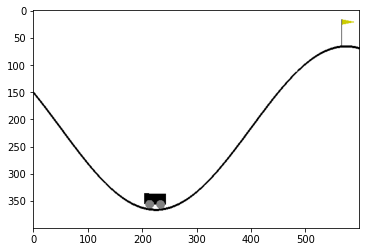

Q-value of the current state left=-64.64 nothing=-64.18 right=-64.67
Action: Nothing


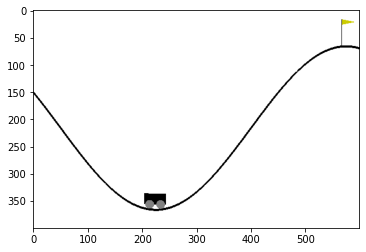

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.67
Action: Nothing


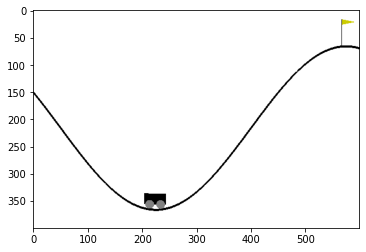

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.66
Action: Nothing


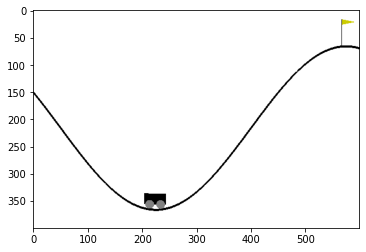

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.66
Action: Nothing


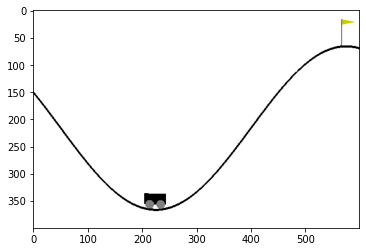

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.66
Action: Nothing


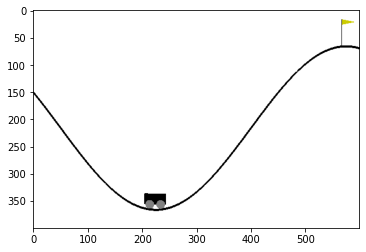

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.66
Action: Nothing


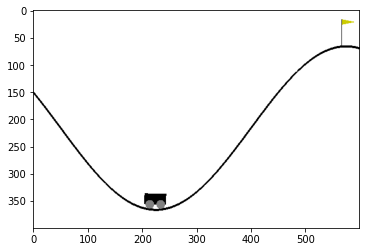

Q-value of the current state left=-64.64 nothing=-64.17 right=-64.65
Action: Nothing


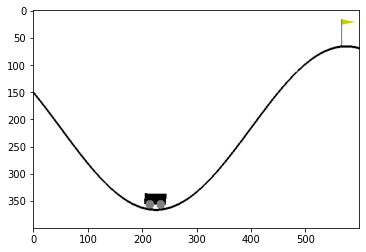

Q-value of the current state left=-64.65 nothing=-64.17 right=-64.65
Action: Nothing


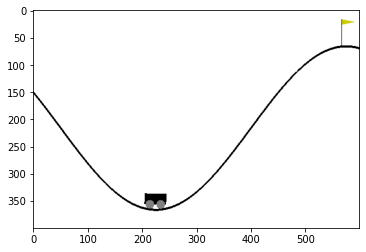

Q-value of the current state left=-64.65 nothing=-64.17 right=-64.65
Action: Nothing


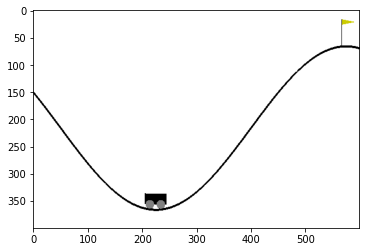

Q-value of the current state left=-64.65 nothing=-64.17 right=-64.65
Action: Nothing


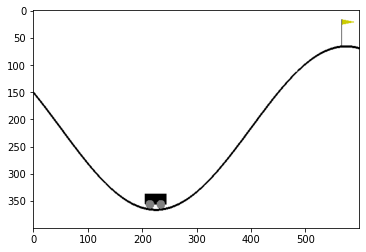

Q-value of the current state left=-64.65 nothing=-64.17 right=-64.65
Action: Nothing


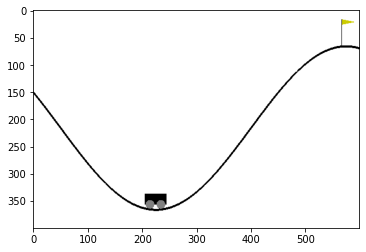

Q-value of the current state left=-64.65 nothing=-64.17 right=-64.65
Action: Nothing


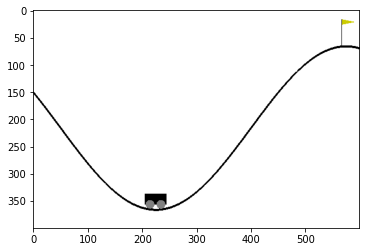

Q-value of the current state left=-64.66 nothing=-64.18 right=-64.65
Action: Nothing


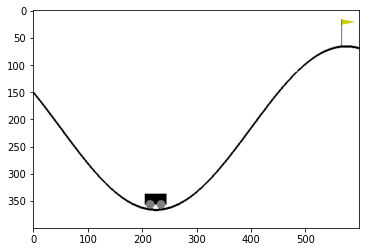

Q-value of the current state left=-64.66 nothing=-64.18 right=-64.65
Action: Nothing


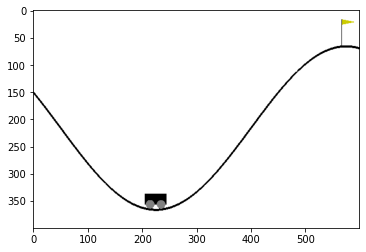

Q-value of the current state left=-64.66 nothing=-64.18 right=-64.65
Action: Nothing


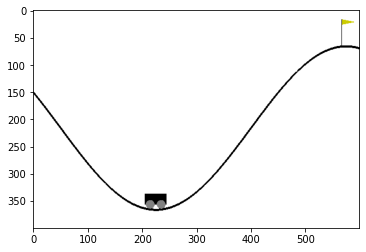

Q-value of the current state left=-64.67 nothing=-64.18 right=-64.65
Action: Nothing


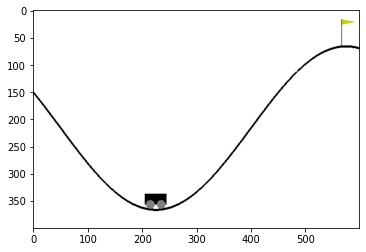

Q-value of the current state left=-64.67 nothing=-64.18 right=-64.65
Action: Nothing


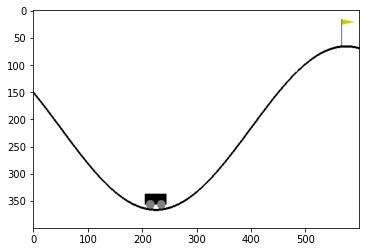

Q-value of the current state left=-64.68 nothing=-64.19 right=-64.65
Action: Nothing


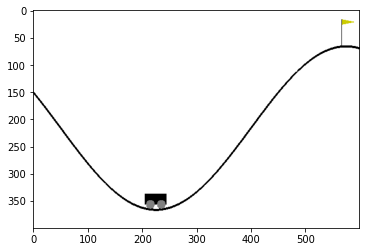

Q-value of the current state left=-64.68 nothing=-64.19 right=-64.66
Action: Nothing


In [28]:
episode_rewards = []
done = False
i = 0

while not done:
    i += 1

    # Display current state
    plt.imshow(train_env.render(mode="rgb_array"))
    plt.show()

    # Retrieve q-value
    q_values = get_q_values(dqn_vanilla, obs)

    # Take greedy-action
    action, _ = dqn_vanilla.predict(obs, deterministic=True)

    print(f"Q-value of the current state left={q_values[0]:.2f} nothing={q_values[1]:.2f} right={q_values[2]:.2f}")
    print(f"Action: {action_str[action]}")

    obs, reward, done, info = train_env.step(action)

    episode_rewards.append(reward)


Step 9: Exercise (3 minutes) - compare estimated initial q-value with actual discounted return
Compute the discounted return (sum of discounted reward) of the episode and compare it to the initial estimated q-value.

Note: You will need to use the discount factor dqn_model.gamma

In [29]:
sum_discounted_rewards = 0

### YOUR CODE HERE
# Compute the sum of discounted reward for the last episode
# using `episode_rewards` list and `dqn_model.gamma` discount factor

count = 0
for reward in episode_rewards:
  reward = reward * (dqn_vanilla.gamma**count)
  sum_discounted_rewards = sum_discounted_rewards + reward
  count = count + 1

### END OF YOUR CODE

print(f"Sum discounted rewards: {sum_discounted_rewards:.2f}, initial q-value {initial_q_value:.2f}")

Sum discounted rewards: -86.60, initial q-value -64.25
